In [1]:
!pip install transformers datasets wandb

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
from datasets import load_dataset

import pandas as pd

df = pd.read_csv('Annotated_story_pairs2.csv')
df['text'] = '#Sentence:' + df['Shared_stories'] + '#Sentence:' + df['Response_strories']
df['label'] = df['Rate']

df[['text', 'label']].to_csv('Annotated_story_pairs3.csv', index=False)

dataset = load_dataset("csv", data_files="Annotated_story_pairs3.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

In [5]:
ds = tokenized_dataset['train'].train_test_split(test_size=0.1, shuffle=True, seed=42)
ds_test = ds['test']
ds_train = ds['train'].train_test_split(test_size=0.15, shuffle=True, seed=42)
ds_val = ds_train['test']
ds_train = ds_train['train']

In [6]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
%env WANDB_PROJECT = Empathy_project

env: WANDB_PROJECT=Empathy_project


In [8]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='Stories10',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    report_to='wandb'
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.126309
2,No log,0.100448
3,No log,0.105290
4,No log,0.104922
5,No log,0.098878
6,No log,0.119871
7,No log,0.102051
8,No log,0.112424
9,No log,0.113656
10,No log,0.112685


TrainOutput(global_step=390, training_loss=0.06747521131466597, metrics={'train_runtime': 672.8247, 'train_samples_per_second': 9.126, 'train_steps_per_second': 0.58, 'total_flos': 1615487374970880.0, 'train_loss': 0.06747521131466597, 'epoch': 10.0})

In [9]:
'''metrics = trainer.evaluate()
print(metrics)'''

'metrics = trainer.evaluate()\nprint(metrics)'

In [11]:
predictions1 = trainer.predict(ds_test)


In [12]:
predictions1

PredictionOutput(predictions=array([[0.52341187],
       [0.7411137 ],
       [0.7771829 ],
       [0.57661027],
       [0.66793406],
       [0.3376425 ],
       [0.68405074],
       [0.6977652 ],
       [0.793115  ],
       [0.68471956],
       [0.77159333],
       [0.7958264 ],
       [0.761064  ],
       [0.8737527 ],
       [0.5494682 ],
       [0.9014212 ],
       [0.71547484],
       [0.72771055],
       [0.6877243 ],
       [0.63230455],
       [0.34564415],
       [0.73694843],
       [1.0061916 ],
       [0.65844643],
       [0.3563912 ],
       [0.876576  ],
       [0.77476597],
       [0.6446122 ],
       [0.66913354],
       [0.7581607 ],
       [0.8001904 ],
       [0.6833557 ],
       [0.6836417 ],
       [0.49811426],
       [0.31724775],
       [0.4442938 ],
       [0.84026796],
       [0.48023218],
       [0.8139095 ],
       [0.9047798 ],
       [0.7606409 ],
       [0.2949279 ],
       [0.83594763],
       [0.23726243],
       [0.10519405],
       [0.90928125],
     

In [13]:
import pickle

with open('predictions1.pkl', 'wb') as f:
    pickle.dump(predictions1, f)

In [18]:
with open('stories_ds_test1.pkl', 'wb') as f:
    pickle.dump(ds_test, f)

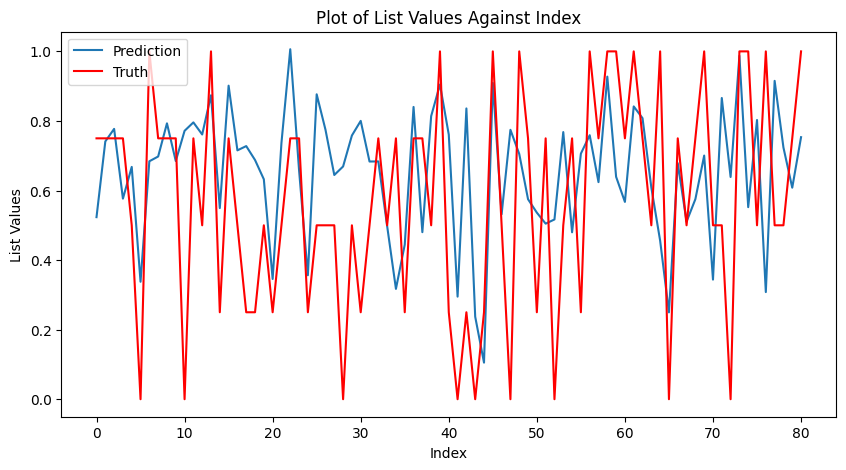

In [33]:
import matplotlib.pyplot as plt


# Set the figure size (width, height in inches)
plt.figure(figsize=(10, 5))

# Plot the first list
plt.plot(predictions1.predictions, label='Prediction')

# Plot the second list in red
plt.plot(predictions1.label_ids, color='red', label='Truth')

# Add labels, title, and a legend
plt.xlabel('Index')
plt.ylabel('List Values')
plt.title('Plot of List Values Against Index')
plt.legend()

# Show the plot
plt.show()
